# Dutch Corpora

In [25]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

#%pip install --upgrade pip  # Required for properly resolving dependencies
#%pip uninstall -y tempo_embeddings  # Remove existing installation
#%pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git
%pip install -e ../ # to pull the "local" tempo embeddings and automatically register code changes when debugging
%pip install chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Obtaining file:///Users/jose/Repos/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=8953 sha256=52ecc029d0448a7aa3f6929c8e1093cfcfaab993a3965ff19641c2d87215c323
  Stored in directory: /private/var/folders/79/zf67ls7520x9m4mj7nx6q07w0000gp/T/pip-ephem-wheel-cache-dd0j1ruy/wheels/de/25/96/d92b7a130b730e0ab67770d76841f36cb3d1f9cda3

In [26]:
# make sure installation has succeeded
import tempo_embeddings

In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

NOTE: You have to manually adapt the `DATA_DIR` below.

In [29]:
%autoreload now

import operator
from functools import reduce
from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [30]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 200
RANDOM_SAMPLE_STATEN_GENERAAL = 200

STATEN_GENERAAL_BLACKLIST = ["1987"]

FILTER_TERMS = ["duurzaam"]  # Search term(s) for filtering the corpus

In [31]:
## NOTE: Adapt the `DATA_DIR` below manually!
## For a shared Google Drive, create a shortcut into your own Google Drive
## See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

LOCAL_PATHS: list[Path] = [
    Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris",
    Path.home() / "SEED_DATA" / "SemanticsSustainability", # local angel
    Path("/data/volume_2/data"),  # Research Cloud
    Path("/home/cschnober/data/"),  # Snellius
]

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    DATA_DIR = Path("/content/drive/MyDrive/Data/")
else:
    try:
        DATA_DIR = next(path for path in LOCAL_PATHS if path.is_dir())
    except StopIteration as e:
        raise DirectoryNotFoundError(f"Data directory not found.") from e

assert DATA_DIR.is_dir(), f"Data dir '{DATA_DIR}' not found."

### ANP

In [32]:
ANP_DIR = DATA_DIR / "ANP"
assert RANDOM_SAMPLE_ANP == 0 or ANP_DIR.is_dir(), f"{ANP_DIR} not found."

In [33]:
import random


random.seed(0)

anp_files = list(ANP_DIR.glob("ANP_????.csv.gz"))

if RANDOM_SAMPLE_ANP and len(anp_files) > RANDOM_SAMPLE_ANP:
    anp_files = random.sample(
        list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP
    )

print(f"Found {len(anp_files)} ANP Files")
anp_files[:10]

Found 2 ANP Files


[PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/ANP/ANP_1983.csv.gz'),
 PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/ANP/ANP_1984.csv.gz')]

In [34]:
anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(anp_files, unit="file")
        ),
    )
    if anp_files
    else Corpus()
)

len(anp_corpus)

100%|██████████| 2/2 [00:01<00:00,  1.82file/s]


55

### Staten Generaal

In [35]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert RANDOM_SAMPLE_STATEN_GENERAAL == 0 or STATEN_GENERAAL_DIR.is_dir()

In [36]:
glob195x = "StatenGeneraal_19[0-9]?.csv.gz"  # Pattern for files from 1950-1999
glob20xx = "StatenGeneraal_2???.csv.gz"  # Pattern for files from 2000

files_195x = list(STATEN_GENERAAL_DIR.glob(glob195x))
files_20xx = list(STATEN_GENERAAL_DIR.glob(glob20xx))

sg_files = [
    file
    # Merge files from patterns
    for file in files_20xx + files_195x
    # Remove blacklisted files:
    for blacklisted in STATEN_GENERAAL_BLACKLIST
    if blacklisted not in file.name
]

if RANDOM_SAMPLE_STATEN_GENERAAL and RANDOM_SAMPLE_STATEN_GENERAAL < len(sg_files):
    sg_files = random.sample(sg_files, k=RANDOM_SAMPLE_STATEN_GENERAAL)

print(f"Found {len(sg_files)} STAATEN_G Files")
sorted(sg_files[:10])

Found 2 STAATEN_G Files


[PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/StatenGeneraal/StatenGeneraal_2017.csv.gz'),
 PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/StatenGeneraal/StatenGeneraal_2018.csv.gz')]

In [37]:
%autoreload now

import csv

csv.field_size_limit(100000000)

sg_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["Content"],
                encoding="utf-8",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(sg_files, unit="file")
        ),
    )
    if sg_files
    else Corpus()
)

len(sg_corpus)

100%|██████████| 2/2 [00:01<00:00,  1.14file/s]


1512

In [38]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

210 Passage('economische groei consequent milieuvernietiging op, in meerdere of mindere mate. Economische groei zou "duurzaam" te noemen zijn als die wordt gekoppeld aan technologische vooruitgang en toenemende efficiëntie.', {'': '204', 'RecId': 'h-ek-20162017-14-3', 'chamber': 'EersteKamer', 'date': '2017-01-17', 'speakers': 'De voorzitter :|Mevrouw Teunissen ( PvdD ):|Mevrouw Vos ( GroenLinks ):|De heer Van Hattem ( PVV ):|Mevrouw Stienen ( D66 ):|De heer Verheijen ( PvdA ):|Mevrouw Meijer ( SP ):|De voorzitter :|Minister Schultz van Haegen-Maas Geesteranus :|Mevrouw Vos ( GroenLinks ):|Minister Schultz van Haegen-Maas Geesteranus :|Mevrouw Vos ( GroenLinks ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Verheijen ( PvdA ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Verheijen ( PvdA ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Van Hattem ( PVV ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Van Hattem ( PVV ):|Minister Schultz van Haegen-

### Merge

In [39]:
corpus = anp_corpus + sg_corpus
len(corpus)

1567

## Load Model

In [40]:
%autoreload now

LAYER = 9

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
    SentenceTransformerModelWrapper,
)

kwargs = {"accelerate": True}

### RoBERTa Models
# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

### XMod Models
# MODEL_NAME = "facebook/xmod-base"
# kwargs["default_language"] = "nl_XX"
# model_class = XModModelWrapper

### BERT Models
# MODEL_NAME = "GroNLP/bert-base-dutch-cased"
# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

### Sentence Transformers
MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
# MODEL_NAME = "textgain/allnli-GroNLP-bert-base-dutch-cased"
model_class = SentenceTransformerModelWrapper

model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)
model

## Create or Open existing Database

In [41]:
EMBED_CONFIG = {"type":"custom"}

from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager
db_custom = ChromaDatabaseManager(db_path="testing_db_custom", embedder_name=MODEL_NAME,embedder_config=EMBED_CONFIG, batch_size=10)
db_custom.connect()

collection_name = "anp_sg_corpus"
loaded_existing_collection = False

anp_sg_collection = db_custom.create_new_collection(collection_name)
if not anp_sg_collection:
    anp_sg_collection = db_custom.get_existing_collection(collection_name)
    loaded_existing_collection = True

Database Path 'testing_db_custom' already exists. Loading current configuration
{'embedder_name': 'NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers', 'embedder_type': 'custom', 'requires_explicit_embeddings': True, 'existing_collections': ['anp_sg_corpus']}
Collection 'anp_sg_corpus' already exists. Not doing anything. (You can delete it or use the 'get_existing_collection' method)


## Compute & Save Embeddings (If DB didn't existed)

In [42]:
%autoreload now

from tempo_embeddings.embeddings.model import EmbeddingsMethod

if not loaded_existing_collection:
    model.batch_size = 128
    model.embeddings_method = EmbeddingsMethod.MEAN

    embeds = model.compute_embeddings(corpus)
    embeddings_full, embeddings_xy = embeds["embeddings_full"], embeds["embeddings_xy"]
    db_custom.insert_passages_embeddings(anp_sg_collection, corpus.passages, embeddings_full)
    corpus.embeddings = embeddings_xy
else:
    # This hack should be improved. We need to re-think the whole tokenization process...
    for p in corpus.passages:
        p.tokenization = db_custom._tokenize(p.text)
    # Generate 2-Dim Embeddings that will be clustered later
    two_dim_embeddings = db_custom.compress_embeddings(anp_sg_collection, persist_in_db=True)
    if two_dim_embeddings is not None:
        corpus.embeddings = two_dim_embeddings
        print(len(corpus.embeddings))

UMAP( verbose=True)
Tue Jan 30 14:00:30 2024 Construct fuzzy simplicial set
Tue Jan 30 14:00:31 2024 Finding Nearest Neighbors
Tue Jan 30 14:00:31 2024 Finished Nearest Neighbor Search
Tue Jan 30 14:00:31 2024 Construct embedding


Epochs completed:  13%| █▎         63/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  48%| ████▊      242/500 [00:01]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  72%| ███████▏   361/500 [00:01]

	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]

	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jan 30 14:00:33 2024 Finished embedding


Corresponding Datapoints (datapoint_x, datapoint_y) were saved in the database
1567


## TESTS: Retrieve Records from Database

In [43]:
%autoreload now

records = db_custom.get_records(anp_sg_collection, filter_words=["toekomst"], where_obj={'$and': [{'year': {'$eq': '1983'}}, {'month': {'$eq': '7'}}]})

print(records["ids"])

for x in records["documents"][:10]:
    print(x)
    print(db_custom.is_in_collection(anp_sg_collection, x))
    print(db_custom.get_vector_from_db(anp_sg_collection, x))
    print(db_custom.embed_text_batch([x]))
    print("-----")

print(len(records["ids"]))
print([len(x) for x in corpus.embeddings[:10]])

['-530282130201327719', '3661270066588500292', '7525817650470106926', '7626710763469064748', '9199030947474922532']
10. proeant verminderen, vergeleken met cijftien Éffocent vorig jacr 11. * Ondanks de iets betere verwachting rekent het N. V. O. B, niet  12  13.  14.  15.  op een" duurzaam herstel in de nabije toekomst".
True
[0.044000592082738876, 0.5028094053268433, 0.40409010648727417, -0.2145041674375534, 0.061154428869485855, 0.6823855042457581, 0.6089086532592773, -0.07533901184797287, -0.6683584451675415, -0.22133800387382507, 0.394042044878006, -0.4483984708786011, 1.1600298881530762, -0.5866367816925049, 0.4052762985229492, -0.5025914311408997, 0.49999186396598816, 0.5941616892814636, 0.08693292737007141, 0.5285694599151611, -0.8090816140174866, -0.4031139016151428, 0.13084329664707184, -0.2474062442779541, -0.32796934247016907, 0.6078358888626099, 0.4891953766345978, -0.46770885586738586, 0.4899234473705292, -0.10758708417415619, 0.45539742708206177, -0.1965370774269104, 0.07

## Read Stopwords

In [44]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: command not found: wget


In [45]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [46]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(10, [0, 37, 40, 41, 126, 131, 143, 244, 249, 255]), Subcorpus(-1, [1, 5, 13, 15, 19, 20, 21, 22, 23, 24]), Subcorpus(22, [2, 7, 12, 16, 33, 35, 66, 67, 68, 77]), Subcorpus(23, [3, 108, 132, 154, 205, 243, 305, 473, 549, 564]), Subcorpus(26, [4, 309, 336, 352, 354, 370, 371, 445, 500, 666]), Subcorpus(25, [6, 18, 53, 151, 198, 199, 236, 302, 308, 322]), Subcorpus(9, [8, 118, 146, 180, 223, 239, 296, 362, 472, 481]), Subcorpus(2, [9, 28, 65, 99, 194, 208, 221, 238, 319, 343]), Subcorpus(11, [10, 92, 158, 166, 230, 271, 281, 556, 661, 701]), Subcorpus(7, [11, 89, 102, 185, 264, 280, 542, 643, 864, 907]), Subcorpus(17, [14, 50, 86, 155, 203, 235, 262, 274, 341, 357]), Subcorpus(19, [17, 59, 161, 164, 167, 178, 212, 290, 307, 312]), Subcorpus(4, [25, 44, 142, 145, 150, 152, 153, 174, 193, 215]), Subcorpus(27, [26, 32, 38, 43, 57, 60, 80, 81, 88, 168]), Subcorpus(8, [29, 62, 105, 110, 111, 128, 134, 147, 157, 181]), Subcorpus(16, [30, 250, 392, 572, 725, 730, 969, 1015, 1164, 1274

In [47]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('duurzaamheid; duurzaamheidsinitiatieven; kamer; wetsvoorstel; terug', [0, 37, 40, 41, 126, 131, 143, 244, 249, 255])
Subcorpus('Outliers', [1, 5, 13, 15, 19, 20, 21, 22, 23, 24])
Subcorpus('duurzaamheid; mensen; motie; nederland; constaterende', [2, 7, 12, 16, 33, 35, 66, 67, 68, 77])
Subcorpus('duurzaamheid; graag; mensen; omgevingswaarden; keuze', [3, 108, 132, 154, 205, 243, 305, 473, 549, 564])
Subcorpus('duurzaamheid; heel; belangrijk; vinden; belang', [4, 309, 336, 352, 354, 370, 371, 445, 500, 666])
Subcorpus('wet; duurzaamheid; eerste; staat; 32813', [6, 18, 53, 151, 198, 199, 236, 302, 308, 322])
Subcorpus('duurzaamheid; iedereen; bouwen; mee; willen', [8, 118, 146, 180, 223, 239, 296, 362, 472, 481])
Subcorpus('duurzaamheid; vorige; halen; dezelfde; gezet', [9, 28, 65, 99, 194, 208, 221, 238, 319, 343])
Subcorpus('duurzaamheid; waar; duurzaamheidsverslag; aanleiding; hoge', [10, 92, 158, 166, 230, 271, 281, 556, 661, 701])
Subcorpus('duurzaamheid; handelsakkoord; w

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [48]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

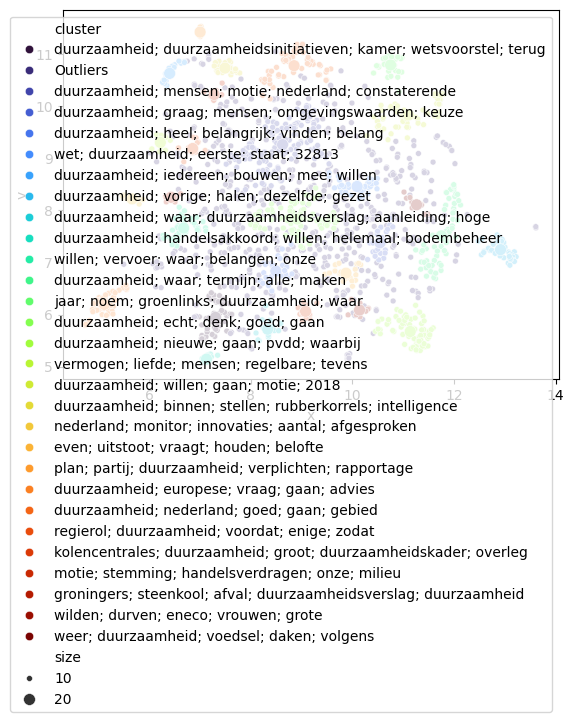

In [49]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [50]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"#"0gvbv9d871k7g8j4h6mppna69o1qlh79dr9fepnuo1qr04mk1hbe"

# NOTE: Bookeh Runs in the 5006 PORT By default...

show(visualizer.create_document)

Loading BokehJS ...